In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay

# Load your features and target
df = pd.read_csv(r'C:\Users\msuma\Desktop\options-trading-bot\data\processed\combined_options_clean.csv')
X = df.drop(columns=["target"])  # Replace "target" with your actual label column
y = df["target"]


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00         6

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



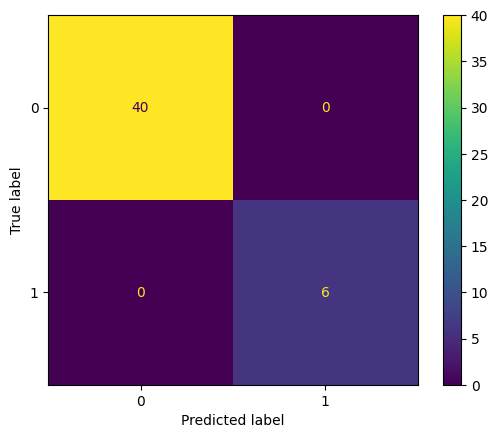

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay
import xgboost as xgb

# Drop non-numeric columns (quick fix to avoid XGBoost error)
X = X.select_dtypes(include=['number'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train XGBoost model (clean version, no deprecation warning)
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Accuracy and report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Display confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)


In [3]:
# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # for ROC-AUC

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00         6

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46

ROC-AUC Score: 1.0


In [4]:
!mkdir images


A subdirectory or file images already exists.


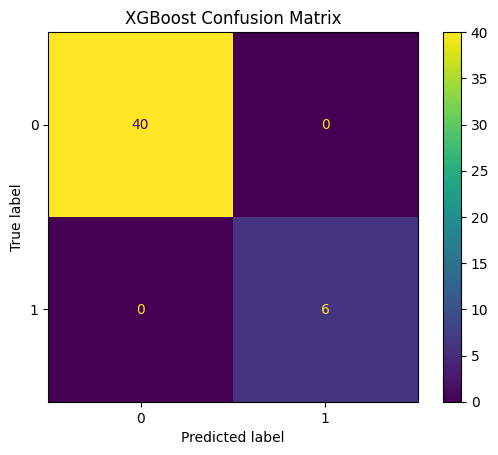

In [5]:
import matplotlib.pyplot as plt

# Display and save confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("XGBoost Confusion Matrix")
plt.savefig("../images/xgboost_confusion.png")
plt.show()
